In [1]:
import torch

print(torch.__version__)

1.12.0a0+bd13bc6


/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip install -q flwr[simulation] torch torchvision matplotlib

ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'INSTALLER'
Consider using the `--user` option or check the permissions.



In [3]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torchvision.datasets import ImageFolder
from typing import Callable, Union

import flwr as fl
from flwr.common import Metrics

torch.cuda.empty_cache()

if torch.cuda.is_available():
    #DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
    DEVICE = torch.device("cpu")
    print(f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}")
else:
    DEVICE = torch.device("cpu")
    print(f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}")

Training on cpu using PyTorch 1.12.0a0+bd13bc6 and Flower 1.3.0


In [4]:
CLASSES = (
    "glioma",
    "meningioma",
    "notumor",
    "pituitary",
    
)

In [5]:
NUM_CLIENTS = 10
BATCH_SIZE = 64
CLIENT_EPOCHS = 5
NR_ROUNDS = 15   # nr of rounds the federated learning should do
LEARNING_RATE = 0.0001

TIME = time.time()
TIME_ = time.time()

accuracies = []
losses = []

predicted_ = []
true_ = []

In [6]:
# Get the new dataset for Brain tumor MRI scans
def load_datasets():
    # Make sure all the images are of the same size. Transform in ImageFolder
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(size=(224, 224)), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    
    #Federated_learning_flower/dataset/brain_tumor_mri/Training
    train_data = ImageFolder(root='dataset/brain_tumor_mri/Training', transform=transform)
    test_data = ImageFolder(root='dataset/brain_tumor_mri/Testing', transform=transform)

    # Split datasets into number of clients.
    #partition_size = int(len(train_data) / NUM_CLIENTS)
    partition_size = len(train_data) // NUM_CLIENTS
    remainders = len(train_data) % NUM_CLIENTS
    percentage = NUM_CLIENTS / 100
    lengths = [partition_size] * NUM_CLIENTS
    #lengths = [percentage] * NUM_CLIENTS
    num = remainders
    for i in range(len(lengths)):
        if num > 0:
            lengths[i] = lengths[i] + 1
        num -= 1
    generator = torch.Generator().manual_seed(42)
    print(len(train_data))
    print(lengths)
    print(remainders)
    datasets = random_split(train_data, lengths, generator=generator)

    # Create trainloaders and valloaders
    trainloaders = []
    valloaders = []
    for i in datasets:
        len_val = len(i) // NUM_CLIENTS
        len_train = len(i) - len_val
        lengths = [len_train, len_val]
        #print(f'len train:{len_train}, len_val: {len_val}')
        i_train, i_val = random_split(i, lengths, torch.Generator().manual_seed(42))

        i_trainloader = DataLoader(i_train, batch_size=BATCH_SIZE, shuffle=True)
        i_valloader = DataLoader(i_val, batch_size=BATCH_SIZE)
        trainloaders.append(i_trainloader)
        valloaders.append(i_valloader)

    testloader = DataLoader(test_data, batch_size=BATCH_SIZE)

    return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = load_datasets()

5175
[518, 518, 518, 518, 518, 517, 517, 517, 517, 517]
5


In [7]:

class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 56 * 56, 120)
        #self.fc1 = nn.Linear(16 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = x.view(-1, 16 * 3 * 3)
        #print('x_shape:',x.shape)
        x = x.view(-1, 16 * 56 * 56)
        #x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [8]:
'''
# VGG16
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()     
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(256, 512 ,kernel_size=3 ,padding=1)
        self.conv9 = nn.Conv2d(512 ,512 ,kernel_size=3 ,padding=1)
        self.conv10 = nn.Conv2d(512 ,512 ,kernel_size=3 ,padding=1)
        self.conv11 = nn.Conv2d(512 ,512 ,kernel_size=3 ,padding=1)
        self.conv12 = nn.Conv2d(512 ,512 ,kernel_size=3 ,padding=1)
        self.conv13 = nn.Conv2d(512 ,512 ,kernel_size=3 ,padding=1)

        # Define the pooling layer
        self.pool = nn.MaxPool2d(kernel_size=(2), stride=(2))
        self.relu = nn.ReLU(True)
        self.dropout = nn.Dropout(0.3)  # Dropout to help avoid overfitting

        # Define the fully connected layers
        self.fc14 = nn.Linear(in_features=(25088), out_features=(4096))
        self.fc15 =nn.Linear(in_features=(4096), out_features=(4096))
        self.fc16 =nn.Linear(in_features=(4096), out_features=(10))
        
         # Define the output layer
         # Note: num_classes is a parameter that can be changed according to the dataset
         # For example: num_classes can be set to 1000 for ImageNet dataset
         # or 10 for CIFAR-10 dataset

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool(x)
        
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.pool(x)
        
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.pool(x)
        
        x = self.conv11(x)
        x = self.conv12(x)
        x = self.conv13(x)
        x = self.pool(x)
        
        x = torch.flatten(x,1)
        
        x = self.fc14(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc15(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc16(x)
        
        return x
'''

'\n# VGG16\nclass Net(nn.Module):\n    def __init__(self) -> None:\n        super(Net, self).__init__()     \n        # Define the convolutional layers\n        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)\n        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)\n        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)\n        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)\n        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)\n        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)\n        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)\n        self.conv8 = nn.Conv2d(256, 512 ,kernel_size=3 ,padding=1)\n        self.conv9 = nn.Conv2d(512 ,512 ,kernel_size=3 ,padding=1)\n        self.conv10 = nn.Conv2d(512 ,512 ,kernel_size=3 ,padding=1)\n        self.conv11 = nn.Conv2d(512 ,512 ,kernel_size=3 ,padding=1)\n        self.conv12 = nn.Conv2d(512 ,512 ,kernel_size=3 ,padding=1)\n        self.conv13 = nn.Conv2d(51

In [9]:
# Simpler model


In [10]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    #print('train function running!')
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            #print(f'data shape: {images.shape}')
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            predicted_.append(predicted)    # Add predicted to list so it is possible to create confusion matrix
            true_.append(labels)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [11]:
def get_parameters(net) -> List[np.ndarray]:
    #print('get_parameters. state_dict')
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    #print('set_parameters. state_dict')
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [12]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=CLIENT_EPOCHS)
        #print('fittin!')
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [13]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""
    
    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    #print(f'client_fn, train and valloader nr {int(cid)}')
    
    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

In [14]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [15]:
# The `evaluate` function will be by Flower called after every round
# Centralized evaluation of the aggregated model

def evaluate(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = Net().to(DEVICE)
    valloader = valloaders[0]
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, valloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}, round {server_round}")
    accuracies.append(accuracy)
    losses.append(loss)
    time_now = time.time()
    time_sofar = time_now - TIME
    #time_used = time_now - TIME_
    #TIME_ = time.time()
    #print(f'Time used on this round: {time_used}')
    print(f'Time used so far: {time_sofar}')
    return loss, {"accuracy": accuracy}


In [16]:
# Function making it possible to sent parameters to the clients
def get_on_fit_config_fn() -> Callable[[int], Dict[str, str]]:
    """Return a function which returns training configurations."""

    def fit_config(server_round: int) -> Dict[str, str]:
        """Return a configuration with static batch size and (local) epochs."""
        config = {
            "learning_rate": str(LEARNING_RATE),
            "batch_size": str(BATCH_SIZE),
        }
        return config

    return fit_config

In [17]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
#strategy = fl.server.strategy.FedAdagrad(
    # Fraction_fit means how many of the clients participate every round. 1.0 = 100%, 0.5 = 50%
    fraction_fit=1.0,
    fraction_evaluate=0.5,    # percentage of clients randomly selected for evaluation
    min_fit_clients=NUM_CLIENTS,    # could be lower than num_clients
    #min_fit_clients=5,
    min_evaluate_clients=NUM_CLIENTS,
    #min_evaluate_clients=10,
    min_available_clients=NUM_CLIENTS,
    #min_available_clients=10,   # Wait until 10 clients are available should be NUM_CLIENTS
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    evaluate_fn = evaluate,
    on_fit_config_fn=get_on_fit_config_fn(),  
    #initial_parameters=fl.common.ndarrays_to_parameters(get_parameters(Net())), # used for FedAdagrad
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}
    print('cuda?')
    
#print('Yo got here!')

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NR_ROUNDS),  #num_rounds = 10
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-04-18 11:10:36,397 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
2023-04-18 11:10:38,789	INFO worker.py:1538 -- Started a local Ray instance.
INFO flwr 2023-04-18 11:10:40,461 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU': 12.0, 'GPU': 16.0, 'node:192.168.4.146': 1.0, 'accelerator_type:V100': 1.0, 'object_store_memory': 24845522534.0, 'memory': 49691045070.0}
INFO flwr 2023-04-18 11:10:40,464 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-18 11:10:40,465 | server.py:270 | Requesting initial parameters from one random client
(launch_and_get_parameters pid=6118) /opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
(launch_

Server-side evaluation loss 0.027108264904396207 / accuracy 0.2549019607843137, round 0
Time used so far: 8.886254787445068


(launch_and_fit pid=6121) /opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
(launch_and_fit pid=6121)   warnings.warn(
(launch_and_fit pid=6109) /opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
(launch_and_fit pid=6109)   warnings.warn(
(launch_and_fit pid=6119) /opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the fu

Server-side evaluation loss 0.019538920299679626 / accuracy 0.6666666666666666, round 1
Time used so far: 85.38951182365417


DEBUG flwr 2023-04-18 11:12:02,973 | server.py:179 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-04-18 11:12:02,974 | server.py:215 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-04-18 11:13:12,528 | server.py:229 | fit_round 2 received 10 results and 0 failures
INFO flwr 2023-04-18 11:13:14,385 | server.py:116 | fit progress: (2, 0.010860473501916025, {'accuracy': 0.7843137254901961}, 149.3999168742448)
DEBUG flwr 2023-04-18 11:13:14,389 | server.py:165 | evaluate_round 2: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.010860473501916025 / accuracy 0.7843137254901961, round 2
Time used so far: 158.37306785583496


DEBUG flwr 2023-04-18 11:13:16,150 | server.py:179 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-04-18 11:13:16,152 | server.py:215 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-04-18 11:14:25,740 | server.py:229 | fit_round 3 received 10 results and 0 failures
INFO flwr 2023-04-18 11:14:27,799 | server.py:116 | fit progress: (3, 0.010818456902223475, {'accuracy': 0.8235294117647058}, 222.8144168239087)
DEBUG flwr 2023-04-18 11:14:27,879 | server.py:165 | evaluate_round 3: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.010818456902223475 / accuracy 0.8235294117647058, round 3
Time used so far: 231.78770232200623


DEBUG flwr 2023-04-18 11:14:29,567 | server.py:179 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-04-18 11:14:29,569 | server.py:215 | fit_round 4: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-04-18 11:15:38,103 | server.py:229 | fit_round 4 received 10 results and 0 failures
INFO flwr 2023-04-18 11:15:39,999 | server.py:116 | fit progress: (4, 0.011158481532452153, {'accuracy': 0.8235294117647058}, 295.01447036862373)
DEBUG flwr 2023-04-18 11:15:40,000 | server.py:165 | evaluate_round 4: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.011158481532452153 / accuracy 0.8235294117647058, round 4
Time used so far: 303.98786664009094


DEBUG flwr 2023-04-18 11:15:41,414 | server.py:179 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-04-18 11:15:41,416 | server.py:215 | fit_round 5: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-04-18 11:16:49,792 | server.py:229 | fit_round 5 received 10 results and 0 failures
INFO flwr 2023-04-18 11:16:51,997 | server.py:116 | fit progress: (5, 0.010112396642273548, {'accuracy': 0.8627450980392157}, 367.0126696564257)
DEBUG flwr 2023-04-18 11:16:52,001 | server.py:165 | evaluate_round 5: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.010112396642273548 / accuracy 0.8627450980392157, round 5
Time used so far: 375.98454213142395


DEBUG flwr 2023-04-18 11:16:53,606 | server.py:179 | evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-04-18 11:16:53,607 | server.py:215 | fit_round 6: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-04-18 11:18:02,935 | server.py:229 | fit_round 6 received 10 results and 0 failures
INFO flwr 2023-04-18 11:18:04,998 | server.py:116 | fit progress: (6, 0.01080028917275223, {'accuracy': 0.8235294117647058}, 440.0138352140784)
DEBUG flwr 2023-04-18 11:18:05,080 | server.py:165 | evaluate_round 6: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.01080028917275223 / accuracy 0.8235294117647058, round 6
Time used so far: 448.98712682724


DEBUG flwr 2023-04-18 11:18:06,494 | server.py:179 | evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-04-18 11:18:06,495 | server.py:215 | fit_round 7: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-04-18 11:19:15,024 | server.py:229 | fit_round 7 received 10 results and 0 failures
INFO flwr 2023-04-18 11:19:17,001 | server.py:116 | fit progress: (7, 0.012483076722014184, {'accuracy': 0.8235294117647058}, 512.0165194328874)
DEBUG flwr 2023-04-18 11:19:17,083 | server.py:165 | evaluate_round 7: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.012483076722014184 / accuracy 0.8235294117647058, round 7
Time used so far: 520.9872546195984


DEBUG flwr 2023-04-18 11:19:18,775 | server.py:179 | evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-04-18 11:19:18,777 | server.py:215 | fit_round 8: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-04-18 11:20:27,827 | server.py:229 | fit_round 8 received 10 results and 0 failures
INFO flwr 2023-04-18 11:20:29,793 | server.py:116 | fit progress: (8, 0.012495051412021412, {'accuracy': 0.8235294117647058}, 584.8084312882274)
DEBUG flwr 2023-04-18 11:20:29,797 | server.py:165 | evaluate_round 8: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.012495051412021412 / accuracy 0.8235294117647058, round 8
Time used so far: 593.7800877094269


DEBUG flwr 2023-04-18 11:20:31,429 | server.py:179 | evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-04-18 11:20:31,431 | server.py:215 | fit_round 9: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-04-18 11:21:39,862 | server.py:229 | fit_round 9 received 10 results and 0 failures
INFO flwr 2023-04-18 11:21:41,588 | server.py:116 | fit progress: (9, 0.014432193017473408, {'accuracy': 0.8235294117647058}, 656.603082511574)
DEBUG flwr 2023-04-18 11:21:41,590 | server.py:165 | evaluate_round 9: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.014432193017473408 / accuracy 0.8235294117647058, round 9
Time used so far: 665.5764214992523


DEBUG flwr 2023-04-18 11:21:43,129 | server.py:179 | evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2023-04-18 11:21:43,131 | server.py:215 | fit_round 10: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-04-18 11:22:50,850 | server.py:229 | fit_round 10 received 10 results and 0 failures
INFO flwr 2023-04-18 11:22:52,497 | server.py:116 | fit progress: (10, 0.012458998782961977, {'accuracy': 0.8235294117647058}, 727.5125227440149)
DEBUG flwr 2023-04-18 11:22:52,498 | server.py:165 | evaluate_round 10: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.012458998782961977 / accuracy 0.8235294117647058, round 10
Time used so far: 736.4854090213776


DEBUG flwr 2023-04-18 11:22:53,847 | server.py:179 | evaluate_round 10 received 10 results and 0 failures
DEBUG flwr 2023-04-18 11:22:53,849 | server.py:215 | fit_round 11: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-04-18 11:24:02,206 | server.py:229 | fit_round 11 received 10 results and 0 failures
INFO flwr 2023-04-18 11:24:03,986 | server.py:116 | fit progress: (11, 0.011750596411087933, {'accuracy': 0.8431372549019608}, 799.0019300617278)
DEBUG flwr 2023-04-18 11:24:03,988 | server.py:165 | evaluate_round 11: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.011750596411087933 / accuracy 0.8431372549019608, round 11
Time used so far: 807.9752771854401


DEBUG flwr 2023-04-18 11:24:05,426 | server.py:179 | evaluate_round 11 received 10 results and 0 failures
DEBUG flwr 2023-04-18 11:24:05,427 | server.py:215 | fit_round 12: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-04-18 11:25:13,917 | server.py:229 | fit_round 12 received 10 results and 0 failures
INFO flwr 2023-04-18 11:25:15,792 | server.py:116 | fit progress: (12, 0.013073232828402052, {'accuracy': 0.8431372549019608}, 870.8076442535967)
DEBUG flwr 2023-04-18 11:25:15,794 | server.py:165 | evaluate_round 12: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.013073232828402052 / accuracy 0.8431372549019608, round 12
Time used so far: 879.7810287475586


DEBUG flwr 2023-04-18 11:25:17,331 | server.py:179 | evaluate_round 12 received 10 results and 0 failures
DEBUG flwr 2023-04-18 11:25:17,332 | server.py:215 | fit_round 13: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-04-18 11:26:25,328 | server.py:229 | fit_round 13 received 10 results and 0 failures
INFO flwr 2023-04-18 11:26:26,783 | server.py:116 | fit progress: (13, 0.0143621844403884, {'accuracy': 0.8431372549019608}, 941.798560956493)
DEBUG flwr 2023-04-18 11:26:26,784 | server.py:165 | evaluate_round 13: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.0143621844403884 / accuracy 0.8431372549019608, round 13
Time used so far: 950.7719321250916


DEBUG flwr 2023-04-18 11:26:28,191 | server.py:179 | evaluate_round 13 received 10 results and 0 failures
DEBUG flwr 2023-04-18 11:26:28,193 | server.py:215 | fit_round 14: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-04-18 11:27:36,445 | server.py:229 | fit_round 14 received 10 results and 0 failures
INFO flwr 2023-04-18 11:27:38,795 | server.py:116 | fit progress: (14, 0.01354542666790532, {'accuracy': 0.8431372549019608}, 1013.8102220501751)
DEBUG flwr 2023-04-18 11:27:38,801 | server.py:165 | evaluate_round 14: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.01354542666790532 / accuracy 0.8431372549019608, round 14
Time used so far: 1022.7835640907288


DEBUG flwr 2023-04-18 11:27:40,174 | server.py:179 | evaluate_round 14 received 10 results and 0 failures
DEBUG flwr 2023-04-18 11:27:40,176 | server.py:215 | fit_round 15: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-04-18 11:28:48,501 | server.py:229 | fit_round 15 received 10 results and 0 failures
INFO flwr 2023-04-18 11:28:50,495 | server.py:116 | fit progress: (15, 0.013189981965457691, {'accuracy': 0.8627450980392157}, 1085.5108426958323)
DEBUG flwr 2023-04-18 11:28:50,497 | server.py:165 | evaluate_round 15: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.013189981965457691 / accuracy 0.8627450980392157, round 15
Time used so far: 1094.4841566085815


DEBUG flwr 2023-04-18 11:28:51,963 | server.py:179 | evaluate_round 15 received 10 results and 0 failures
INFO flwr 2023-04-18 11:28:51,964 | server.py:144 | FL finished in 1086.9801259357482
INFO flwr 2023-04-18 11:28:51,967 | app.py:202 | app_fit: losses_distributed [(1, 0.01994631418994829), (2, 0.010986526573405547), (3, 0.009870655396405388), (4, 0.009454600922032898), (5, 0.009395891135814145), (6, 0.009473355172895917), (7, 0.00920075519996531), (8, 0.009096667842537749), (9, 0.010371064292449576), (10, 0.009491091645231434), (11, 0.009596948281807056), (12, 0.010023911092795578), (13, 0.010680043828838012), (14, 0.011280667840265763), (15, 0.01095075516724119)]
INFO flwr 2023-04-18 11:28:51,968 | app.py:203 | app_fit: metrics_distributed {'accuracy': [(1, 0.6313725490196078), (2, 0.784313725490196), (3, 0.8274509803921568), (4, 0.8372549019607843), (5, 0.8470588235294118), (6, 0.8588235294117647), (7, 0.8666666666666666), (8, 0.8745098039215685), (9, 0.8647058823529413), (10, 0

History (loss, distributed):
	round 1: 0.01994631418994829
	round 2: 0.010986526573405547
	round 3: 0.009870655396405388
	round 4: 0.009454600922032898
	round 5: 0.009395891135814145
	round 6: 0.009473355172895917
	round 7: 0.00920075519996531
	round 8: 0.009096667842537749
	round 9: 0.010371064292449576
	round 10: 0.009491091645231434
	round 11: 0.009596948281807056
	round 12: 0.010023911092795578
	round 13: 0.010680043828838012
	round 14: 0.011280667840265763
	round 15: 0.01095075516724119
History (loss, centralized):
	round 0: 0.027108264904396207
	round 1: 0.019538920299679626
	round 2: 0.010860473501916025
	round 3: 0.010818456902223475
	round 4: 0.011158481532452153
	round 5: 0.010112396642273548
	round 6: 0.01080028917275223
	round 7: 0.012483076722014184
	round 8: 0.012495051412021412
	round 9: 0.014432193017473408
	round 10: 0.012458998782961977
	round 11: 0.011750596411087933
	round 12: 0.013073232828402052
	round 13: 0.0143621844403884
	round 14: 0.01354542666790532
	round 1

In [18]:
print(accuracies)
print(losses)

[0.2549019607843137, 0.6666666666666666, 0.7843137254901961, 0.8235294117647058, 0.8235294117647058, 0.8627450980392157, 0.8235294117647058, 0.8235294117647058, 0.8235294117647058, 0.8235294117647058, 0.8235294117647058, 0.8431372549019608, 0.8431372549019608, 0.8431372549019608, 0.8431372549019608, 0.8627450980392157]
[0.027108264904396207, 0.019538920299679626, 0.010860473501916025, 0.010818456902223475, 0.011158481532452153, 0.010112396642273548, 0.01080028917275223, 0.012483076722014184, 0.012495051412021412, 0.014432193017473408, 0.012458998782961977, 0.011750596411087933, 0.013073232828402052, 0.0143621844403884, 0.01354542666790532, 0.013189981965457691]


<function matplotlib.pyplot.show(close=None, block=None)>

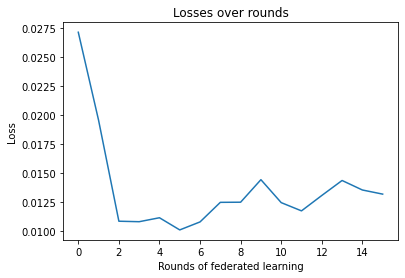

In [19]:
import matplotlib.pyplot as plt 
import numpy as np


# Losses
nr = int(len(losses))
x_losses = list(range(nr))
y_losses = losses

plt.plot(x_losses, y_losses)
plt.title('Losses over rounds')
plt.xlabel('Rounds of federated learning')
plt.ylabel('Loss')
plt.savefig('losses.png')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

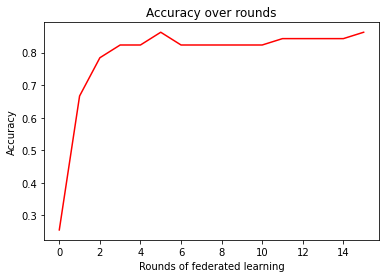

In [20]:
# Accuracy
nrr = int(len(accuracies))
x_acc = list(range(nrr))
y_acc = accuracies

plt.plot(x_acc, y_acc, color='red')
plt.title('Accuracy over rounds')
plt.xlabel('Rounds of federated learning')
plt.ylabel('Accuracy')
plt.savefig('accuracy.png')
plt.show

In [21]:
print(f'Num clients: {NUM_CLIENTS}')
print(f'Num federation rounds: {NR_ROUNDS}')
print(f'Batch size: {BATCH_SIZE}')
print(f'Client epochs: {CLIENT_EPOCHS}')
print(f'Client learning rate: {LEARNING_RATE}')

print(f'Accuracy: {accuracies[-1]}')

Num clients: 10
Num federation rounds: 15
Batch size: 64
Client epochs: 5
Client learning rate: 0.0001
Accuracy: 0.8627450980392157


In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#print(true_)
#print(predicted_)


[tensor([1, 3, 2, 3, 0, 2, 3, 3, 3, 3, 1, 0, 3, 2, 1, 2, 3, 1, 3, 2, 2, 0, 1, 2,
        0, 0, 1, 1, 2, 3, 1, 0, 1, 1, 0, 2, 1, 2, 3, 1, 2, 0, 1, 2, 3, 0, 2, 3,
        3, 1, 0]), tensor([1, 3, 2, 3, 0, 2, 3, 3, 3, 3, 1, 0, 3, 2, 1, 2, 3, 1, 3, 2, 2, 0, 1, 2,
        0, 0, 1, 1, 2, 3, 1, 0, 1, 1, 0, 2, 1, 2, 3, 1, 2, 0, 1, 2, 3, 0, 2, 3,
        3, 1, 0]), tensor([1, 3, 2, 3, 0, 2, 3, 3, 3, 3, 1, 0, 3, 2, 1, 2, 3, 1, 3, 2, 2, 0, 1, 2,
        0, 0, 1, 1, 2, 3, 1, 0, 1, 1, 0, 2, 1, 2, 3, 1, 2, 0, 1, 2, 3, 0, 2, 3,
        3, 1, 0]), tensor([1, 3, 2, 3, 0, 2, 3, 3, 3, 3, 1, 0, 3, 2, 1, 2, 3, 1, 3, 2, 2, 0, 1, 2,
        0, 0, 1, 1, 2, 3, 1, 0, 1, 1, 0, 2, 1, 2, 3, 1, 2, 0, 1, 2, 3, 0, 2, 3,
        3, 1, 0]), tensor([1, 3, 2, 3, 0, 2, 3, 3, 3, 3, 1, 0, 3, 2, 1, 2, 3, 1, 3, 2, 2, 0, 1, 2,
        0, 0, 1, 1, 2, 3, 1, 0, 1, 1, 0, 2, 1, 2, 3, 1, 2, 0, 1, 2, 3, 0, 2, 3,
        3, 1, 0]), tensor([1, 3, 2, 3, 0, 2, 3, 3, 3, 3, 1, 0, 3, 2, 1, 2, 3, 1, 3, 2, 2, 0, 1, 2,
        0, 0, 1, 1, 2, 3

In [23]:
def flat(lis):
    flatList = []
    # Iterate with outer list
    for element in lis:
        if type(element) is list:
            # Check if type is list than iterate through the sublist
            for item in element:
                flatList.append(item)
        else:
            flatList.append(element)
    return flatList

In [24]:
tr = []
pr = []

for i in true_:
    ints = i.tolist()
    tr.append(ints)

for j in predicted_:
    intss = j.tolist()
    pr.append(intss)
    
#print(tr)
#print(pr)

In [25]:
flat_true = flat(tr)
flat_predicted = flat(pr)

#print(flat_true)
#print(flat_predicted)

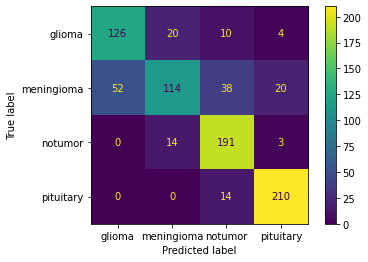

In [28]:
cm = confusion_matrix(flat_true, flat_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["glioma", "meningioma", "notumor", "pituitary"])
disp.plot()
plt.savefig('confusionmatrix.png')
plt.show()

In [29]:
#Federated_learning_flower/dataset/brain_tumor_mri/Testing/notumor/Te-no_0034.jpg
image = 'dataset/brain_tumor_mri/Testing/notumor/Te-no_0034.jpg'
#pred = Net(image)
#print(pred)

In [31]:
#from torchsummary import summary
#summary(Net(), (3, 224, 224))

print(Net())

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)
